## Домашнее задание №8

1. Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики


In [29]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets

from IPython.display import clear_output 

In [9]:
# Зададим функцию

def function(x):
    return (np.sin(x)/x) - (x/10)

In [10]:
# Вызовем пример 
function(2)

0.25464871341284084

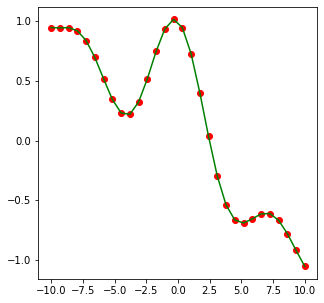

In [11]:
# Визуализируем график функции

fig, ax = plt.subplots(figsize=(5, 5))


# область графика
x = np.linspace(-10, 10, 30)

# рисуем точки 
ax.scatter(x, function(x), color='red')

# рисуем график
plt.plot(x, function(x), color='green')

plt.show()

#### 1. Генерация настоящих данных

In [43]:
x = np.random.uniform(0, 10, size=(1, 400000))[0]

data_train = pd.DataFrame({'x': x,
                           'y': function(x)})
data_train.head(3)

,x,y
0,9.551443,-0.968370
1,8.620453,-0.778481
2,0.640336,0.869015


In [44]:
# Сделаем стандартизацию

scaler = MinMaxScaler()
data_train = scaler.fit_transform(data_train)  
data_train = torch.FloatTensor(data_train)

In [45]:
# Сделаем класс dataset и dataloader

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        # scaler = StandardScaler()
        # self.data = torch.FloatTensor(scaler.fit_transform(data))
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [46]:
# создание экземпляра класса Dataset и Dataloader

batch_size = 128

train_dataset = CustomDataset(data_train)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,
                          num_workers=0)

In [47]:
# проверка корректности даталоадера

for idx, data in enumerate(train_loader):
    print(data.shape)
    break

torch.Size([128, 2])


#### 2. Создание генератора и дискриминатора

In [48]:
# Класс генератора

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]  # Если мы создаем последовательность слоев - то мы задаем их
                                                     # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])  # Эта строчка означает тоже самое что и
                                                         # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),  # Звездочка означает unpacking списка
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
             nn.Linear(1024, 2),
             nn.Linear(2, 2),
             nn.Tanh()
        )
        
    def forward(self, z):
        new_point = self.model(z)
        new_point = new_point.reshape(-1, 2)
        return new_point 

In [49]:
# Кастомный класс линейного слоя

class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in) #задаем тензор - заготовку для весов
        self.weights = nn.Parameter(weights) # Любые веса должны быть обернуты как параметры слоя

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias) # аналогично оборачиваем в параметр

        nn.init.uniform_(self.weights, -0.005, 0.005) # назначаем стартовые веса
        nn.init.uniform_(self.bias, -0.005, 0.005)   # и bias

    def forward(self, x):
        # По формуле линейного слоя:
        w_times_x = torch.mm(x, self.weights.t()) #нам нужно умножить наши данные на транспонированные веса
        return torch.add(w_times_x, self.bias) # и добавить смещение

In [50]:
# Класс Дискриминатора

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512), # количество параметров в датасете (x, y)
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid()
        )
  
    def forward(self, img):
        img_flat = img
        validity = self.model(img_flat)
        return validity

#### 3. Обучение сети GAN и визуализация результата

In [51]:
n_epochs = 20  # количество эпох
lr = 0.0005  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

latent_dim = 100  # Размерность случайного вектора, который подается на вход генератору

sample_interval = 500  # количество итераций для отображения процесса обучения


In [52]:
# Инициализируем генератор и дискриминатор

generator = Generator()
discriminator = Discriminator()

# опитимизатор для каждой сети
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# функция ошибки
adversarial_loss = torch.nn.BCELoss()

In [53]:
d_loss_history = []
g_loss_history = []

In [54]:
# Функция для визуализации точек

def plot_points(gen_points, real_points):
    
    fig, ax = plt.subplots(figsize=(6, 6))

    #отрисовка реальных точек
    x_real, y_real = (real_points.detach()).T
    plt.scatter(x_real, y_real, color='green',label='real_points') 
    
    #отрисовка сгенерированных точек
    x_gen, y_gen = (gen_points.detach()).T
    plt.scatter(x_gen,y_gen, color='red', label='generated_points') 

    plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

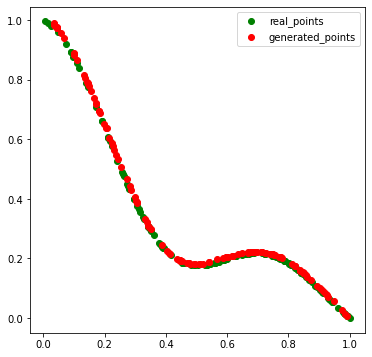

[Epoch 19/20] [Batch 2625/3125]|[D loss: 0.6996906995773315] [G loss: 0.6698365807533264]


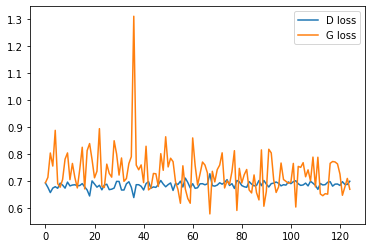

In [55]:
import matplotlib.patches as mpatches

for epoch in range(n_epochs):
    for i, points in enumerate(train_loader):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0) #(B,1) -- столбец-лейблов 1
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0)  #(B,1)  -- столбец-лейблов 0

        real_points = points #.type(torch.FloatTensor) #(B,2) -- реальные данные

        # Генерация шума (B,latent_dim)
        z = torch.FloatTensor(np.random.normal(0, 10, (batch_size, latent_dim)))
        # Генерируем данные Генератором на основе шума
        gen_points = generator(z)   #(B,2) -- сгенерированные данные
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_points)  #(B,1)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_points) #(B,1)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))) #(B,latent_dim)
        
        # Генерируем данные Генератором на основе шума
        gen_points = generator(z)  #(B,2)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_points)  #(B,1)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(train_loader) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()
                clear_output(wait=False)
                plot_points(gen_points, real_points)
                
                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(train_loader)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 


                d_loss = d_loss.cpu().detach()  #новый тензор без градиента
                g_loss = g_loss.cpu().detach()

                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend()
                plt.show() 